# Imports

In [37]:
import pandas as pd
from collections import Counter
import string
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer

# EDA

In [2]:
data = pd.read_csv('../data/Flipkart/flipkart_com-ecommerce_sample_1050.csv')
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [3]:
print(f'This dataset has {df.shape[0]} rows and {df.shape[1]} columns')

This dataset has 1050 rows and 15 columns


## Duplicates

In [4]:
# Check for duplicates on uniq_id
duplicates = df.duplicated(subset='uniq_id')
print(f'This dataset has {duplicates.sum()} duplicates')

This dataset has 0 duplicates


## Missing values

In [5]:
# Get missing values
missing = df.isnull().sum()
print(f'This dataset has {missing.sum()} missing')
brands_missing = df['brand'].isnull().sum()
print(f'{brands_missing} missing values in the brand column')
retail_missing = df['retail_price'].isnull().sum()
print(f'{retail_missing} missing value in the retail_price column')
discount_missing = df['discounted_price'].isnull().sum()
print(f'{discount_missing} missing value in the discounted_price column')

This dataset has 341 missing
338 missing values in the brand column
1 missing value in the retail_price column
1 missing value in the discounted_price column


## Features selection

The objective is to suggest a classification in the appropriate category(ies) based on a product description and/or a product image. We will select the features according to this objective.

In [6]:
# Filter information
to_keep = ['uniq_id', 'product_name', 'product_category_tree', 'description', 'image']
print('As our goal is to create a classifier, we will keep only the following columns:')
for col in to_keep:
    print(f' - {col}')

As our goal is to create a classifier, we will keep only the following columns:
 - uniq_id
 - product_name
 - product_category_tree
 - description
 - image


In [21]:
df = df[to_keep]

## Get the category tree structure

In [22]:
# Get informations about category tree
df['product_category_tree'].apply(lambda x: x.split('>>')[0].replace('["','').replace(']','').strip()).value_counts()


product_category_tree
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [23]:
# Add a column main_category
df['main_category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0].replace('["','').replace(']','').strip())
df.head()

,uniq_id,product_name,product_category_tree,description,image,main_category
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


In [39]:
categories = df['main_category'].unique()
for cat in categories:
    df_home_frunishing = df[df['main_category'] == cat]
    subcat = len(df_home_frunishing.apply(lambda x: x['product_category_tree'].split('>>')[1], axis=1).unique())
    print(f'{cat} has {subcat} sub categories')

KeyError: 'product_category_tree'

In [36]:
# drop tree column
df = df.drop(columns='product_category_tree')

# Text preprocessing

## Product description

### Basic analysis

In [25]:
# Count number of characters in description
df['description_length'] = df['description'].apply(lambda x: len(x))
df['description_length'].describe()

count    1050.000000
mean      473.820952
std       457.910422
min       109.000000
25%       192.000000
50%       278.000000
75%       588.250000
max      3490.000000
Name: description_length, dtype: float64

In [26]:
# How many sentences in a description.
# A sentence starts with a capital letter and ends with a dot.
df['description_sentences'] = df['description'].apply(lambda x: len(x.split('.')))
df['description_sentences'].describe()

count    1050.000000
mean        6.604762
std         4.655836
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        44.000000
Name: description_sentences, dtype: float64

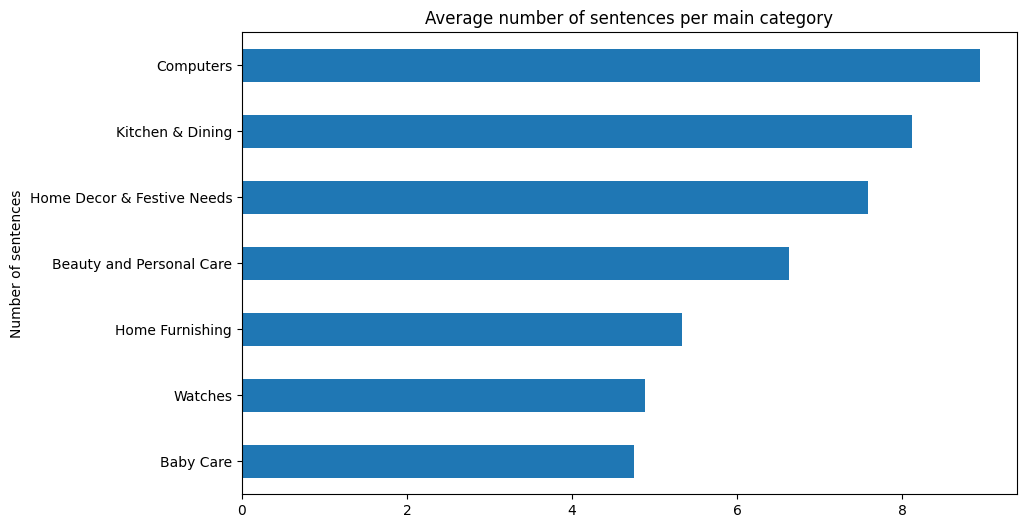

In [33]:
# plot the distribution of the number of sentences per main category ordered by the average number of sentences
# labels should be on the y-axis, and the number of sentences on the x-axis
fig = plt.figure(figsize=(10, 6))
df.groupby('main_category')['description_sentences'].mean().sort_values().plot(kind='barh')
plt.title('Average number of sentences per main category')
plt.ylabel('Number of sentences')
plt.show()

In [27]:
home = df[df['main_category'] == 'Home Furnishing']


,uniq_id,product_name,product_category_tree,description,image,main_category,description_length,description_sentences
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,1420,11
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,858,1
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,1197,6
33,b85f8843bb1c297dd5712f0bd287006d,SANTOSH ROYAL FASHION Cotton Embroidered Diwan...,"[""Home Furnishing >> Living Room Furnishing >>...",Key Features of SANTOSH ROYAL FASHION Cotton E...,b85f8843bb1c297dd5712f0bd287006d.jpg,Home Furnishing,954,4
34,a4b09aa7927c59fbb39960b3d7919909,House This Queen Cotton Duvet Cover,"[""Home Furnishing >> Bed Linen >> Duvet Covers...",Key Features of House This Queen Cotton Duvet ...,a4b09aa7927c59fbb39960b3d7919909.jpg,Home Furnishing,583,2


### NLP

#### Setup

In [15]:
# Download NLTK corpora
nltk.download('stopwords') # empty words (the, a, an, ...)
nltk.download('punkt')
nltk.download('words') # english words
nltk.download('wordnet') # lemmatization
# a (word) sense is a discrete representation of one aspect
# of the meaning of a word
# WordNet is a large lexical database of word senses for English and
# other languages

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
stopwords = nltk.corpus.stopwords.words('english')
words = set(nltk.corpus.words.words())
lemmatizer = WordNetLemmatizer()

In [11]:
def preprocess_list_of_sentences(sentences:list[str])->list[str]:
    """Preprocess a list of sentences

    Args:
        sentences (list): A list of strings

    Returns:
        list: A list of tokens
    """
    preprocessed_sentences = []
    for sentence in sentences:
        # Punctuation
        sentence_no_punc = ''.join([i.lower() for i in sentence if i not in string.punctuation])
        # Numbers
        sentence_no_num = ''.join([i for i in sentence_no_punc if not i.isdigit()])
        # Tokenization
        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_no_num)
        # stopwords
        sentence_no_stopwords = [word for word in tokenize_sentence if word not in stopwords]
        # lemmanization
        sentence_lemmatized = [lemmatizer.lemmatize(word) for word in sentence_no_stopwords]
        # English words
        sentence_english = [word for word in sentence_lemmatized if word.lower() in words or not word.isalpha()]

        preprocessed_sentences.append(' '.join(sentence_english))

    return preprocessed_sentences

#### Preprocessing

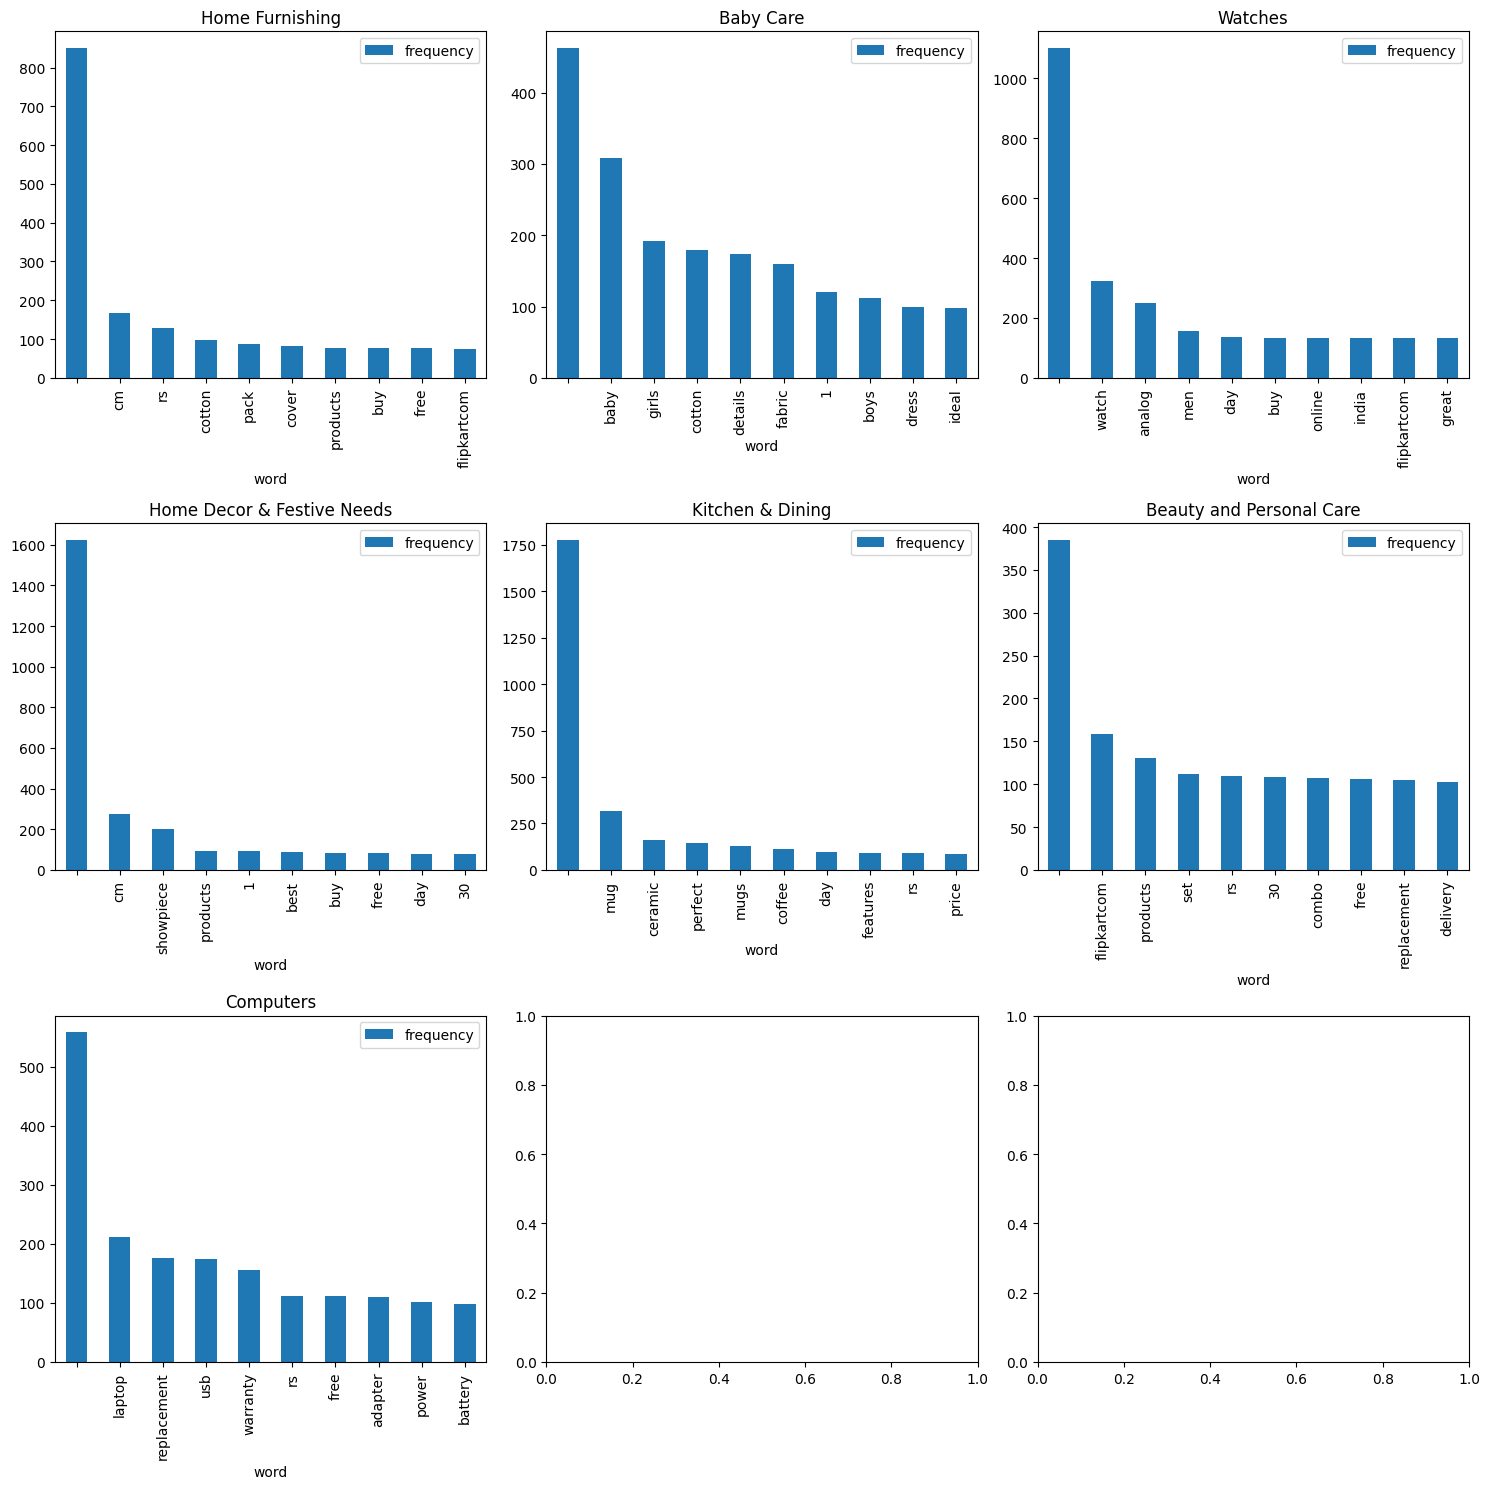

In [65]:
# to lowercase
df['description_preprocessed'] = df['description'].apply(lambda x: x.lower())
# get rid of punctuation
df['description_preprocessed'] = df['description_preprocessed'].apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
# split on ' ' and count the number of words
df['desc_words'] = df['description_preprocessed'].apply(lambda x: x.strip().split(' '))
# remove stopwords
df['desc_words'] = df['desc_words'].apply(lambda x: [word for word in x if word not in stopwords])

# create a dictionnary object where each key is an main_category name and the value contains word frequency
word_freq = {}
for cat in categories:
    df_cat = df[df['main_category'] == cat]
    words = df_cat['desc_words'].sum()
    word_freq[cat] = Counter(words)

# plot the 10 most common words for each main category
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, (cat, freq) in enumerate(word_freq.items()):
    freq_df = pd.DataFrame(freq.most_common(10), columns=['word', 'frequency'])
    freq_df.plot(kind='bar', x='word', y='frequency', ax=axs[i//3, i%3], title=cat)
plt.tight_layout()
plt.show()